# **XGBoost**

In [1]:
import pandas as pd

dataset_work = pd.read_csv('D:\DataSet\dataset_work_transformed.csv')
x = dataset_work.iloc[:,:-1]
y = dataset_work.iloc[:,-1].values
dataset_work.shape

(6435823, 19)

Dividiendo los datos en conjuntos de entrenamiento y prueba

In [2]:
from sklearn.model_selection import train_test_split

# Cargar el dataset
X = dataset_work.drop(columns=['MOROSIDAD']) 
y = dataset_work['MOROSIDAD']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Modelo de XGBoost

Para optimizar su rendimiento, se han seleccionado hiperparámetros mediante un proceso de ajuste previo. El modelo utiliza un enfoque basado en **boosting** con 300 árboles de decisión entrenados secuencialmente. Cada árbol se ajusta utilizando una proporción del 80% de las muestras (`subsample=0.8`) y considerando el 60% de las características en cada división (`colsample_bytree=0.6`). Se emplea una profundidad máxima de 7 niveles por árbol para controlar el sobreajuste, con un peso mínimo requerido en las hojas de 1 (`min_child_weight=1`). Además, el modelo utiliza una tasa de aprendizaje de 0.2 (`learning_rate=0.2`) para reducir la contribución de cada árbol, y un término de regularización gamma de 0.1 para penalizar la complejidad del modelo. 

A continuación, se presenta un resumen de los hiperparámetros seleccionados:

| **Hiperparámetro**       | **Valor Seleccionado** |
|--------------------------|------------------------|
| `subsample`              | 0.8                   |
| `n_estimators`           | 300                   |
| `min_child_weight`       | 1                     |
| `max_depth`              | 7                     |
| `learning_rate`          | 0.2                   |
| `gamma`                  | 0.1                   |
| `colsample_bytree`       | 0.6                   |

El proceso incluye las siguientes etapas principales: entrenamiento del modelo con los datos de entrenamiento, evaluación mediante validación cruzada para calcular el AUC-ROC promedio, predicción en un conjunto de prueba, y cálculo de métricas de desempeño como la matriz de confusión, el informe de clasificación, y el AUC-ROC. Finalmente, se mide el tiempo total de ejecución del proceso. 

In [3]:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score
import time

# Registro del tiempo de inicio
start_time = time.time()

# Configuración del modelo de XGBoost con los hiperparámetros proporcionados
model = XGBClassifier(
    subsample=0.8,             # Proporción de muestras utilizadas para entrenar cada árbol
    n_estimators=300,          # Número de árboles
    min_child_weight=1,        # Peso mínimo de las hojas
    max_depth=7,               # Profundidad máxima de los árboles
    learning_rate=0.2,         # Tasa de aprendizaje (eta)
    gamma=0.1,                 # Parámetro de regularización para reducción de pérdida
    colsample_bytree=0.6,      # Proporción de características a considerar en cada árbol
    random_state=42,           # Semilla para reproducibilidad
    use_label_encoder=False,   # Evitar advertencias en versiones recientes de XGBoost
    eval_metric='logloss'      # Métrica de evaluación
)

# Ajustar el modelo con los datos de entrenamiento
model.fit(X_train, y_train)

# Evaluación del modelo con validación cruzada (cv=3)
auc_scores = cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc')

# Promedio de AUC-ROC
auc_mean = auc_scores.mean()
print(f"AUC-ROC promedio en validación cruzada: {auc_mean:.4f}")  # Mostrar con 4 decimales

# Hacer predicciones en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilidades para la clase positiva

# Evaluar el rendimiento del modelo
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

# Calcular el AUC-ROC en el conjunto de prueba
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC en conjunto de prueba: {roc_auc:.4f}")  # Mostrar con 4 decimales

# Medir el tiempo de finalización y calcular el tiempo transcurrido
end_time = time.time()
elapsed_time = end_time - start_time

# Convertir a minutos y segundos
minutes = elapsed_time // 60
seconds = elapsed_time % 60

print(f"El tiempo total de ejecución fue de {int(minutes)} minutos y {seconds:.2f} segundos.")


C:\Users\hrqui\AppData\Roaming\Python\Python310\site-packages\xgboost\core.py:158: UserWarning: [20:22:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\hrqui\AppData\Roaming\Python\Python310\site-packages\xgboost\core.py:158: UserWarning: [20:23:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\hrqui\AppData\Roaming\Python\Python310\site-packages\xgboost\core.py:158: UserWarning: [20:24:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg,

AUC-ROC promedio en validación cruzada: 0.9187

Matriz de Confusión:
[[909473 211366]
 [135749 674159]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.87      0.81      0.84   1120839
           1       0.76      0.83      0.80    809908

    accuracy                           0.82   1930747
   macro avg       0.82      0.82      0.82   1930747
weighted avg       0.82      0.82      0.82   1930747

ROC AUC en conjunto de prueba: 0.9196
El tiempo total de ejecución fue de 4 minutos y 36.07 segundos.


## **Curva ROC (característica operativa del receptor)**

**Propósito:** Mostrar la relación entre la tasa de verdaderos positivos (TPR) y la tasa de falsos positivos (FPR) para diferentes umbrales de clasificación.

**Beneficio:** Permite evaluar visualmente la capacidad del modelo para distinguir entre las clases y calcular el AUC-ROC (área bajo la curva).

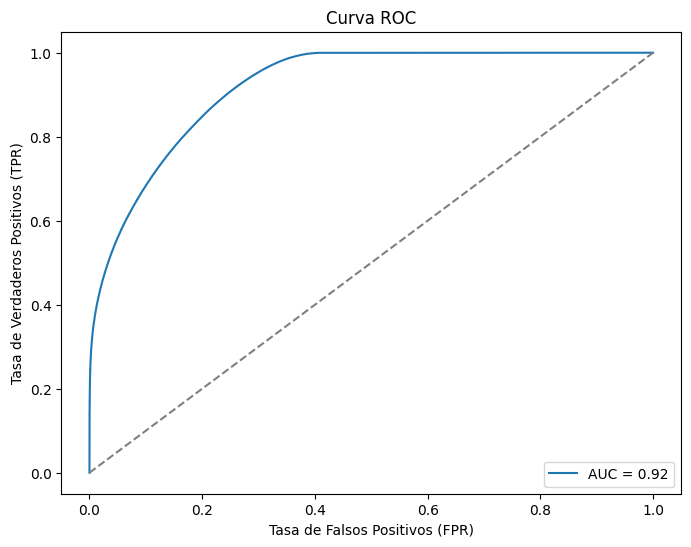

In [4]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.show()


### Análisis del gráfico: Curva ROC

La curva ROC (Receiver Operating Characteristic) muestra el desempeño del modelo XGBoost en la predicción de la morosidad tributaria, evaluando la relación entre la Tasa de Verdaderos Positivos (TPR o Sensibilidad) y la Tasa de Falsos Positivos (FPR) en diferentes umbrales de decisión.

En este caso, el área bajo la curva (AUC = 0.92) indica que el modelo tiene un excelente poder discriminatorio para diferenciar entre contribuyentes morosos y no morosos. Un AUC cercano a 1.0 implica que el modelo es muy efectivo en predecir correctamente las clases, mientras que un AUC de 0.5 correspondería a un modelo aleatorio.

### Interpretación en el contexto de morosidad tributaria:
Un AUC de 0.92 sugiere que el modelo puede identificar de manera precisa a los contribuyentes con alta probabilidad de ser morosos, minimizando falsos positivos (marcar a un contribuyente no moroso como moroso) y maximizando verdaderos positivos (detectar correctamente a los morosos). Esto es especialmente importante en la gestión tributaria, ya que una identificación efectiva permite focalizar recursos en los contribuyentes con mayor riesgo de incumplimiento. Sin embargo, es clave evaluar cómo afecta el umbral de decisión la proporción de errores y las prioridades del problema.

## **Gráfico de Precisión-Recall (Precision-Recall Curve)**
**Propósito:** Evaluar el desempeño del modelo en términos de precisión y sensibilidad (recall) para diferentes umbrales.

**Beneficio:** Es especialmente útil si las clases están desbalanceadas, ya que pone mayor énfasis en los verdaderos positivos.

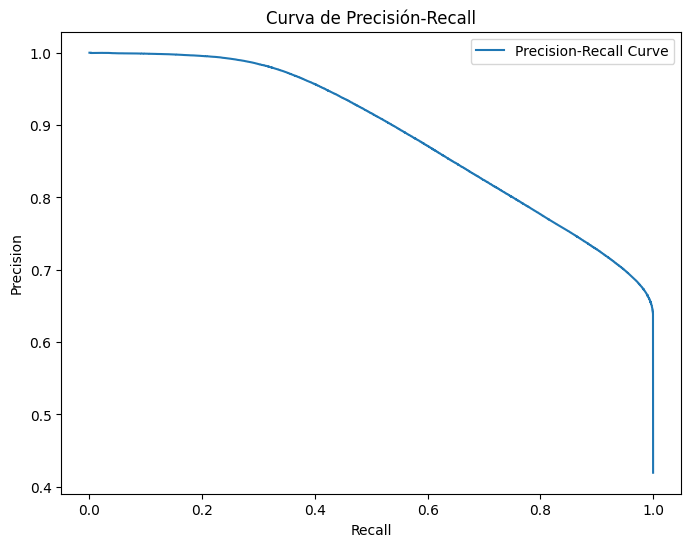

In [5]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva de Precisión-Recall")
plt.legend(loc="upper right")
plt.show()


### Análisis del gráfico: Curva de Precisión-Recall

La curva de Precisión-Recall evalúa el desempeño del modelo XGBoost en términos de **precisión** (proporción de verdaderos positivos sobre todas las predicciones positivas) y **recall** (proporción de verdaderos positivos detectados sobre el total de positivos reales). Este gráfico es particularmente útil en problemas con clases desbalanceadas, como suele ocurrir en la predicción de morosidad tributaria.

### Observaciones del gráfico:
- El modelo mantiene una alta precisión en valores bajos de recall, lo que indica que, inicialmente, las predicciones positivas son altamente confiables, aunque no se detectan todos los morosos.
- A medida que aumenta el recall, la precisión disminuye, reflejando el compromiso típico entre detectar más casos positivos (mayor recall) y evitar incluir falsos positivos (mayor precisión).
- El comportamiento general de la curva muestra un buen desempeño del modelo, dado que no decae bruscamente y mantiene una precisión razonablemente alta incluso en niveles más altos de recall.

### Interpretación en el contexto de morosidad tributaria:
En el caso de la predicción de morosidad tributaria, un balance adecuado entre precisión y recall es crucial. Una alta precisión asegura que los contribuyentes identificados como morosos tienen una alta probabilidad de serlo realmente, reduciendo costos asociados a investigaciones innecesarias. Por otro lado, un alto recall garantiza que la mayoría de los morosos sean identificados, minimizando pérdidas tributarias. Según la curva, el modelo tiene un buen potencial para adaptarse a diferentes prioridades según la estrategia de gestión tributaria, como priorizar la recuperación de ingresos (maximizar recall) o la eficiencia en las acciones de cobro (maximizar precisión).

## **Matriz de Confusión con Mapa de Calor**

**Propósito:** Visualizar la matriz de confusión de forma más interpretativa usando un mapa de calor.

**Beneficio:** Facilitar la identificación de aciertos y errores del modelo en las clases predichas.

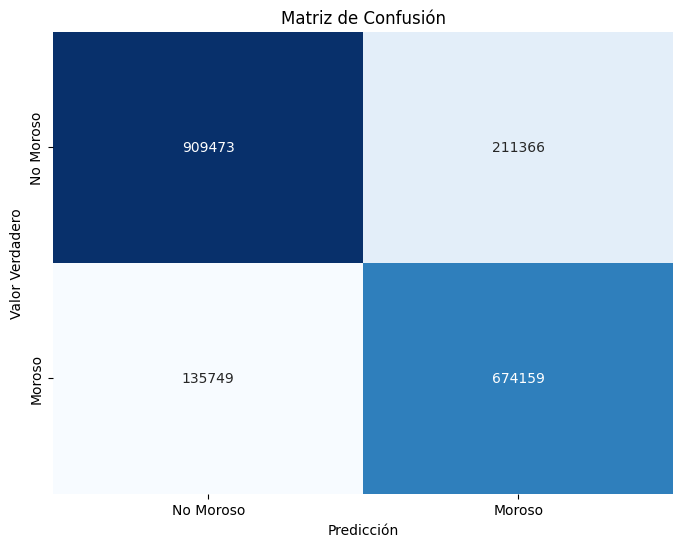

In [6]:
import seaborn as sns
import numpy as np
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Moroso', 'Moroso'], yticklabels=['No Moroso', 'Moroso'])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Valor Verdadero")
plt.show()


### Análisis del gráfico: Matriz de Confusión

La matriz de confusión evalúa el desempeño del modelo XGBoost clasificando correctamente los casos de morosidad y no morosidad tributaria. Los valores indican lo siguiente:

- **Verdaderos Negativos (909,473)**: Contribuyentes correctamente clasificados como no morosos.  
- **Falsos Positivos (21,1366)**: Contribuyentes incorrectamente clasificados como morosos, lo que implica acciones innecesarias.  
- **Falsos Negativos (135,749)**: Contribuyentes morosos no detectados por el modelo, lo que representa ingresos no recuperados.  
- **Verdaderos Positivos (674,159)**: Contribuyentes correctamente identificados como morosos.

### Observaciones clave:
1. El modelo tiene un buen desempeño en identificar a los morosos (674,159) y no morosos (909,473).  
2. Aunque el número de falsos negativos (135,749) es significativo, el modelo logra capturar una alta proporción de contribuyentes morosos.  
3. El número de falsos positivos (211,366) implica que algunos contribuyentes no morosos podrían ser sometidos a investigaciones innecesarias.

### Interpretación en el contexto de morosidad tributaria:
El modelo es efectivo en general, pero los falsos negativos son un aspecto crítico a considerar en este problema, ya que representan contribuyentes morosos no identificados, lo que podría resultar en una pérdida económica para la administración tributaria. Por otro lado, los falsos positivos generan un costo operativo adicional por investigaciones o notificaciones innecesarias. 

La estrategia a seguir dependerá del costo relativo de estos errores. Si es más prioritario minimizar falsos negativos (maximizar el recall), podría ajustarse el umbral de decisión del modelo para mejorar la detección de morosos, aceptando un posible incremento en falsos positivos. Por el contrario, si se busca optimizar recursos operativos, se podría dar prioridad a minimizar los falsos positivos (maximizar la precisión).

## **Importancia de las Características (Coeficientes)**

**Propósito:** Mostrar gráficamente la importancia de las variables en la predicción de la morosidad basada en los coeficientes del modelo de regresión logística.

**Beneficio:** Ayuda a interpretar el modelo ya identificar las variables más influyentes.

C:\Users\hrqui\AppData\Local\Temp\ipykernel_31276\552896770.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coef_df, x='Importancia', y='Características', palette='viridis')


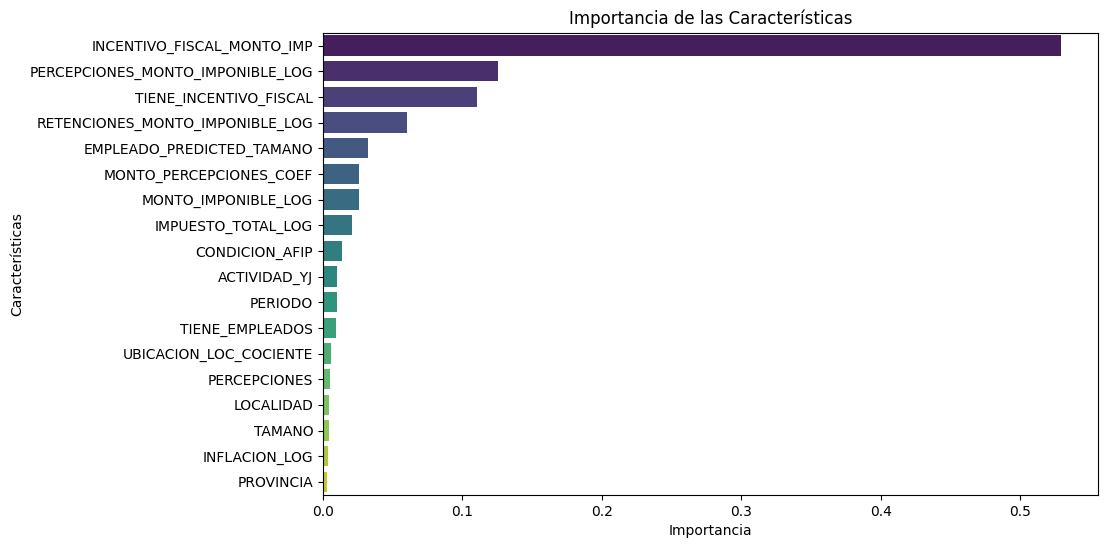

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Obtener la importancia de las características desde el modelo
importances = model.feature_importances_

# Crear un DataFrame con las características y su importancia
coef_df = pd.DataFrame({
    'Características': X_train.columns,
    'Importancia': importances
}).sort_values(by='Importancia', ascending=False)

# Visualización de las importancias
plt.figure(figsize=(10, 6))
sns.barplot(data=coef_df, x='Importancia', y='Características', palette='viridis')
plt.title("Importancia de las Características")
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.show()



### Análisis del gráfico: Importancia de las Características

El gráfico muestra la importancia de las variables utilizadas por el modelo XGBoost en la predicción de la morosidad tributaria. Esta importancia se basa en la contribución de cada característica a las decisiones tomadas por los árboles en el modelo.

### Observaciones clave:
1. **`INCENTIVO_FISCAL_MONTO_IMP`** es, con gran diferencia, la variable más importante. Esto indica que los incentivos fiscales recibidos por los contribuyentes son un factor determinante para predecir la morosidad, lo que sugiere una posible relación entre el aprovechamiento de incentivos y el incumplimiento tributario.
2. **`PERCEPCIONES_MONTO_IMPONIBLE_LOG` y `TIENE_INCENTIVO_FISCAL`** también tienen un peso considerable. Estas variables podrían estar asociadas a patrones de comportamiento financiero que influyen en la probabilidad de morosidad.
3. Otras variables relevantes incluyen **`RETENCIONES_MONTO_IMPONIBLE_LOG`** y **`EMPLEADO_PREDICTED_TAMANO`**, que aportan información sobre el manejo de impuestos retenidos y el tamaño estimado del contribuyente (posiblemente un proxy para su capacidad económica).
4. Variables como **`PROVINCIA`**, **`INFLACION_LOG`** y **`TAMAÑO`** tienen un peso bajo, lo que indica que son menos relevantes para el modelo.

### Interpretación en el contexto de morosidad tributaria:
El análisis de importancia de características sugiere que las variables relacionadas con incentivos fiscales y montos imponibles son cruciales para entender el comportamiento de los contribuyentes morosos. Esto podría reflejar que ciertos contribuyentes utilizan incentivos fiscales como un recurso temporal para cubrir obligaciones, pero eventualmente incurren en morosidad. Además, el tamaño estimado del contribuyente y sus retenciones tributarias también parecen influir en su propensión a incumplir.

Este conocimiento puede ser útil para diseñar estrategias específicas, como una evaluación más estricta de los contribuyentes que reciben incentivos fiscales o focalizar las medidas de cobro en aquellos que manejan altos montos imponibles con retenciones significativas. Por otro lado, variables con baja importancia podrían ser revisadas y potencialmente descartadas para simplificar el modelo sin afectar su desempeño.

## **Distribución de las Probabilidades**

**Propósito:** Mostrar la distribución de las probabilidades predichas para cada clase.

**Beneficio:** Permite analizar cómo el modelo clasifica los datos y si existe algún solapamiento importante entre las clases.

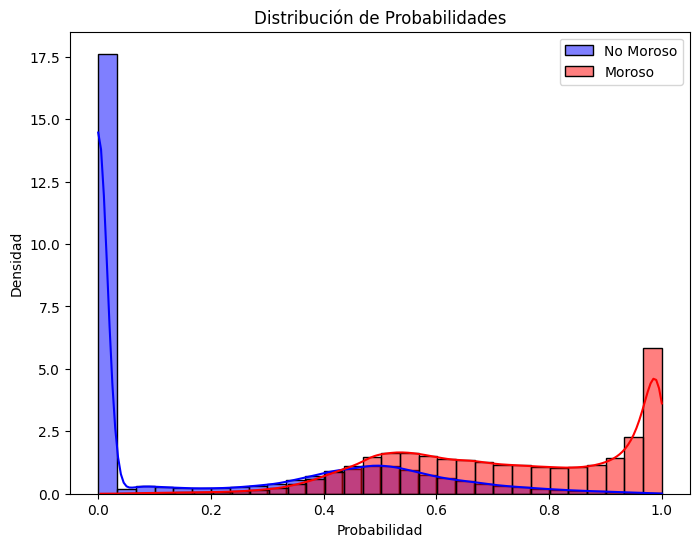

In [8]:
plt.figure(figsize=(8, 6))
sns.histplot(y_pred_proba[y_test == 0], label='No Moroso', color='blue', kde=True, stat='density', bins=30)
sns.histplot(y_pred_proba[y_test == 1], label='Moroso', color='red', kde=True, stat='density', bins=30)
plt.title("Distribución de Probabilidades")
plt.xlabel("Probabilidad")
plt.ylabel("Densidad")
plt.legend()
plt.show()


### Análisis del gráfico: Distribución de Probabilidades

El gráfico muestra la distribución de probabilidades predichas por el modelo XGBoost para las dos clases: **morosos (rojo)** y **no morosos (azul)**. Las probabilidades reflejan el grado de confianza del modelo al clasificar un contribuyente como moroso o no moroso.

### Observaciones clave:
1. **Clase No Moroso**:
   - La mayoría de los contribuyentes no morosos se agrupan cerca de la probabilidad de **0**, indicando que el modelo tiene alta confianza al identificarlos correctamente.
   - Existe un pequeño solapamiento con las probabilidades medias (0.4-0.6), donde hay cierta incertidumbre en la clasificación.

2. **Clase Moroso**:
   - Los contribuyentes morosos tienden a agruparse cerca de la probabilidad de **1**, lo que sugiere que el modelo también tiene alta confianza al predecir esta clase.
   - Se observa un solapamiento con las probabilidades intermedias, lo cual indica la presencia de algunos casos difíciles de clasificar.

3. **Zona de solapamiento**:
   - En el rango de probabilidades medias (aproximadamente entre 0.4 y 0.6), hay una superposición entre las dos clases, lo que representa casos donde el modelo tiene menor seguridad al clasificar. Estos casos suelen ser los más complejos y podrían requerir atención adicional.

### Interpretación en el contexto de morosidad tributaria:
Este gráfico evidencia que el modelo es capaz de asignar probabilidades extremas con confianza en la mayoría de los casos, clasificando correctamente a los morosos y no morosos. Sin embargo, los casos en la zona de solapamiento (probabilidades medias) representan situaciones de mayor ambigüedad, donde el modelo podría cometer errores de clasificación (falsos positivos o falsos negativos).

Desde el punto de vista de la gestión tributaria, estos casos con probabilidades medias podrían ser objeto de análisis más detallado o auditorías adicionales para evitar errores. Además, ajustar el umbral de decisión del modelo podría ayudar a optimizar el balance entre recall (detección de morosos) y precisión (minimización de falsos positivos) según las prioridades estratégicas. Por ejemplo:
- Un umbral más bajo aumentaría la detección de morosos (recall), pero con mayor riesgo de identificar erróneamente a no morosos como morosos.
- Un umbral más alto reduciría falsos positivos, pero podría dejar pasar contribuyentes morosos.